# To


In [14]:
from model import UNetEfficientNetV2
import torch


In [15]:
def get_device():
    """Get the device to use for PyTorch operations (CPU or cuda or MPS)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon)")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = get_device()

Using CUDA


In [16]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

common_transforms = A.Compose([
    A.ShiftScaleRotate(p=0.2),
    A.RandomCrop(height=384, width=384),
    A.HorizontalFlip(p=0.5),
    # ToTensorV2()

])

# Not for mask
image_transforms = A.Compose([
    A.RandomBrightnessContrast(p=0.2),  # Solo per l'immagine
    ToTensorV2()
])

c:\Users\lgand\anaconda3\envs\DL\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [21]:
from datamodule import BinarySegmentationDataset

ds = BinarySegmentationDataset(
    # images_dir='../output_blob/stretched/',
    # masks_dir='../output_blob/masks_man/',
    images_dir='../image_generation/generated/stretched/',
    masks_dir='../image_generation/generated/masks/',
    common_transform= common_transforms,
    image_transform= image_transforms,
    mask_divisor=False
)

In [23]:
import os
from typing import Optional, Tuple
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pytorch_lightning as pl
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np



class BinarySegmentationDataset(Dataset):
    def __init__(self, images_dir: str, masks_dir: str, common_transform=None, image_transform=None, mask_divisor=False):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.common_transform = common_transform
        self.image_transform = image_transform
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))
        self.mask_divisor = mask_divisor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        image = Image.open(img_path).convert("L")  # grayscale PIL image
        mask = Image.open(mask_path).convert("L")  # grayscale PIL image

        # image = np.array(image)[..., None]  # shape (H, W, 1)
        mask = np.array(mask)[..., None]    # shape (H, W, 1)
        image = np.array(image)[..., None]  # shape (H, W, 1)
        if self.common_transform:
            augmented = self.common_transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]
        if self.image_transform:
            image = self.image_transform(image=image)["image"]
        if self.mask_divisor:
            mask = mask // 255
        mask = torch.from_numpy((mask > 0.5)).float().permute(2, 0, 1)
        image = torch.cat([image, image, image], dim=0).float() 
        preprocess = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
        image = preprocess(image)  # Preprocess input
        return image, mask

class BinarySegmentationDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_images_dir: str,
        train_masks_dir: str,
        val_images_dir: str,
        val_masks_dir: str,
        transforms: dict,
        batch_size: int = 8,
        num_workers: int = 4,
        img_size: Tuple[int, int] = (384, 384),
        mask_divisor: bool = False
    ):
        super().__init__()
        self.train_images_dir = train_images_dir
        self.train_masks_dir = train_masks_dir
        self.val_images_dir = val_images_dir
        self.val_masks_dir = val_masks_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = img_size

        self.train_common_transform = transforms["train_common"]
        self.val_common_transform = transforms["val_common"]
        self.train_image_transform = transforms["train_image"]
        self.val_image_transform = transforms["val_image"]
        self.mask_divisor = mask_divisor

        

    def setup(self, ):  #stage: Optional[str] = None):
        self.train_dataset = BinarySegmentationDataset(
            self.train_images_dir,
            self.train_masks_dir,
            common_transform=self.train_common_transform,
            image_transform=self.train_image_transform,
            mask_divisor= self.mask_divisor
        )
        self.val_dataset = BinarySegmentationDataset(
            self.val_images_dir,
            self.val_masks_dir,
            common_transform=self.val_common_transform,
            image_transform=self.val_image_transform,
            mask_divisor= self.mask_divisor
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )


In [29]:
ds = BinarySegmentationDataset(
    # images_dir='../output_blob/stretched/',
    # masks_dir='../output_blob/masks_man/',
    images_dir='../image_generation/generated/stretched/',
    masks_dir='../image_generation/generated/masks/',
    common_transform= common_transforms,
    image_transform= image_transforms,
    mask_divisor=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


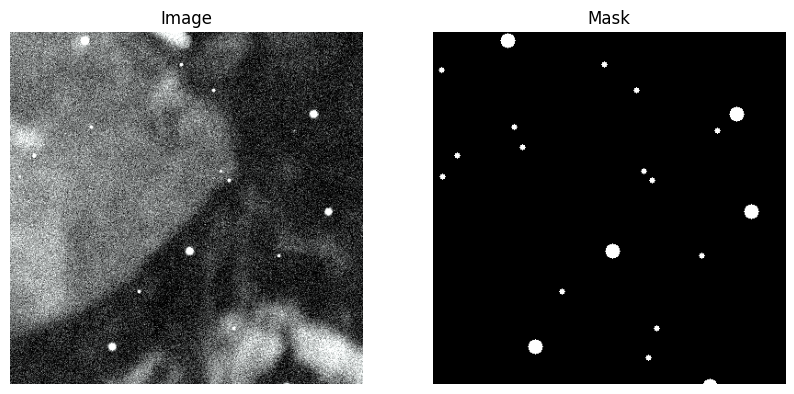

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


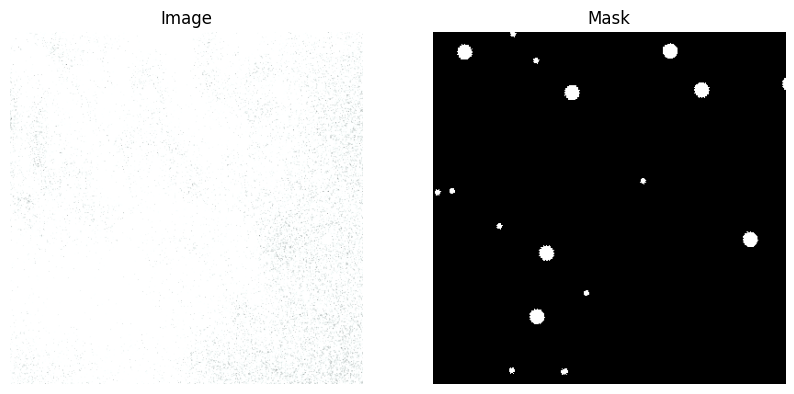

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


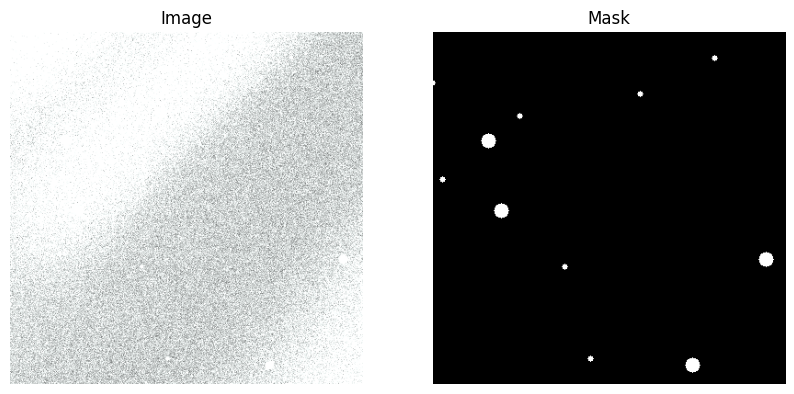

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


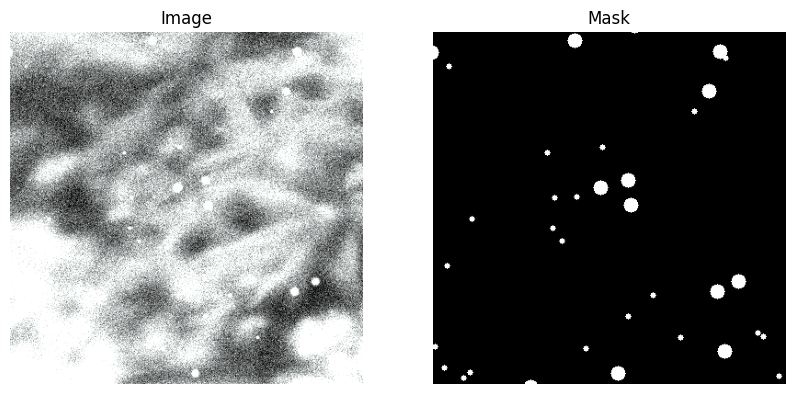

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


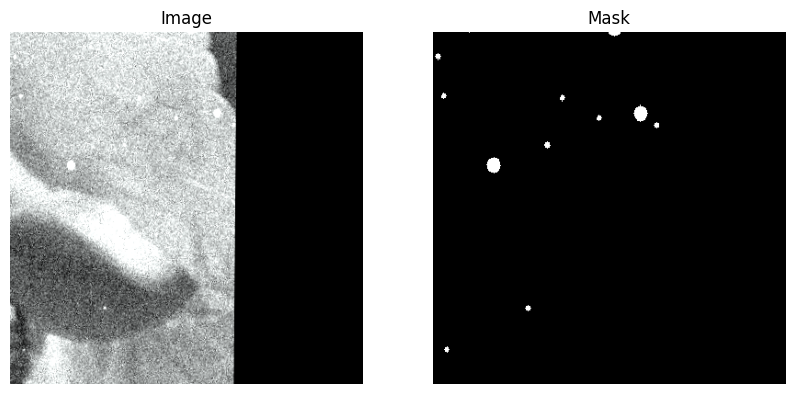

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


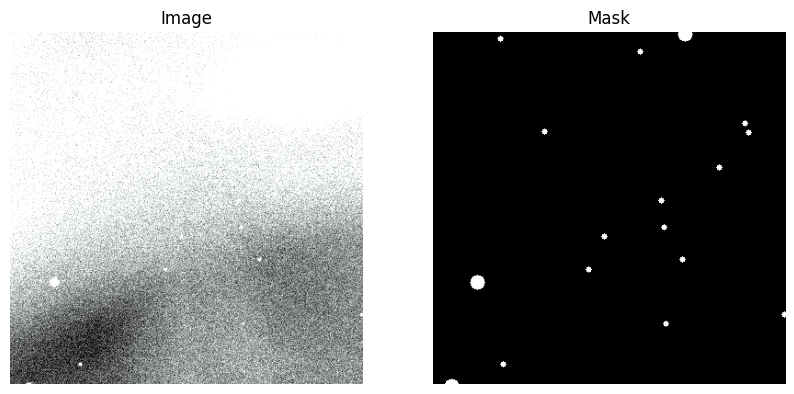

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


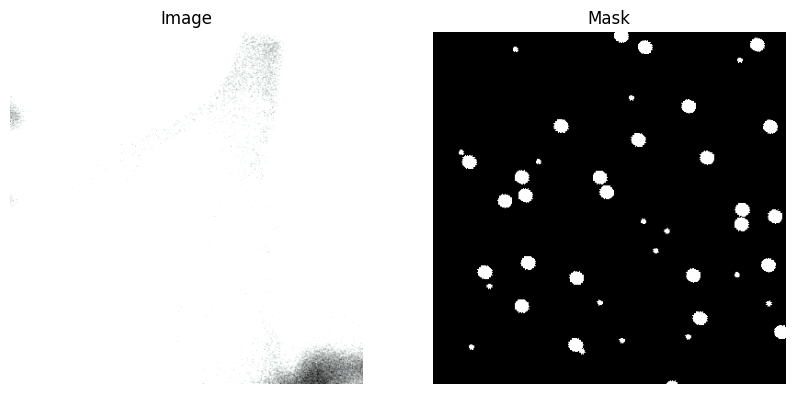

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


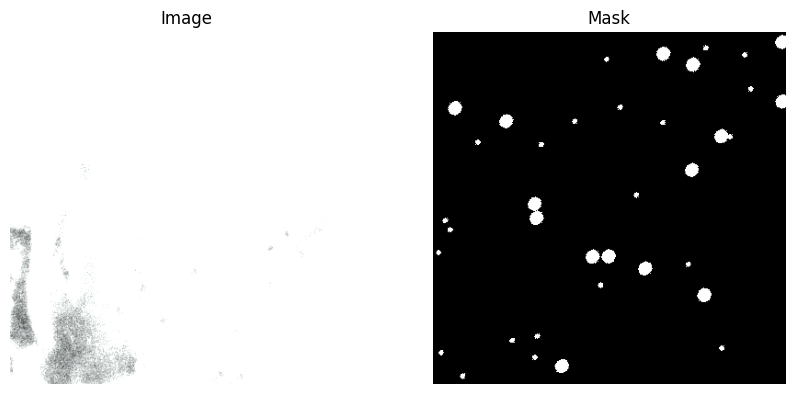

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


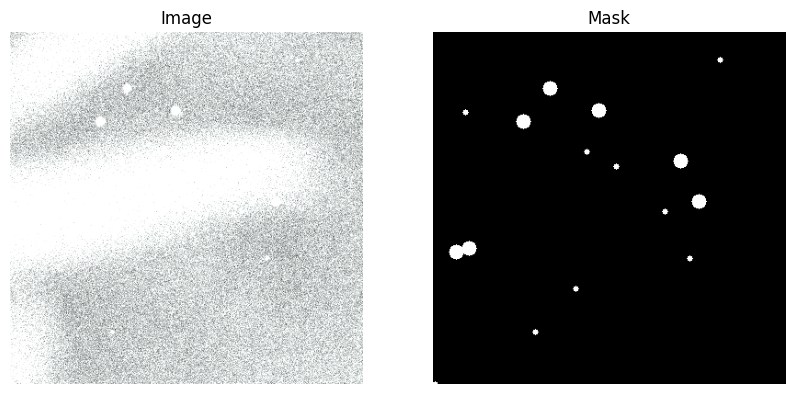

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


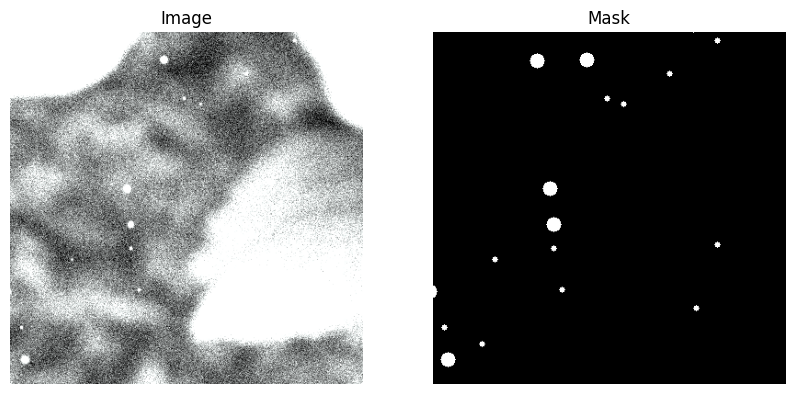

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


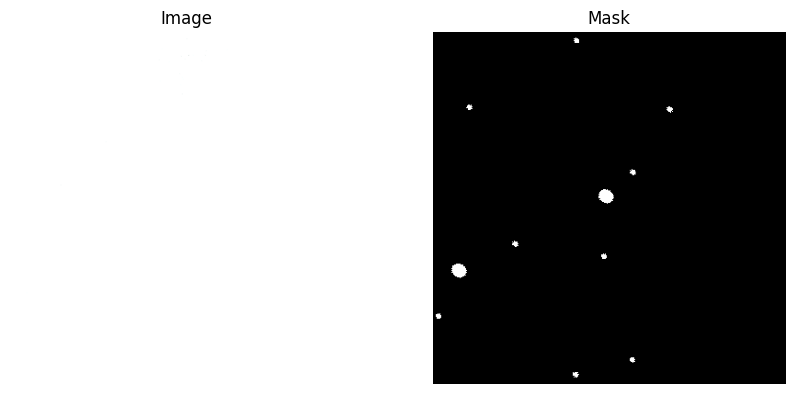

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


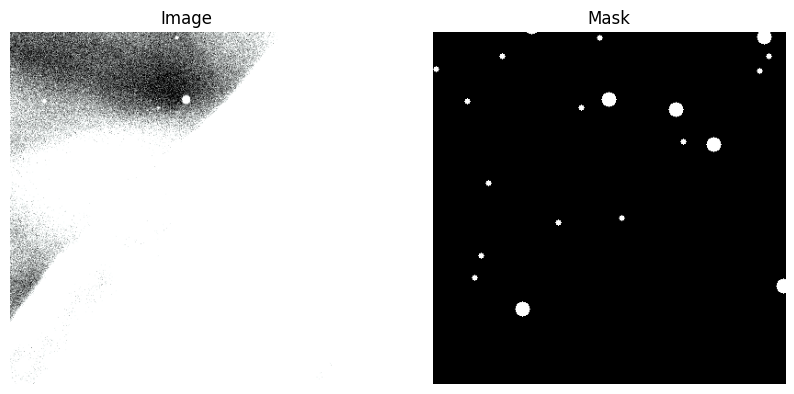

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


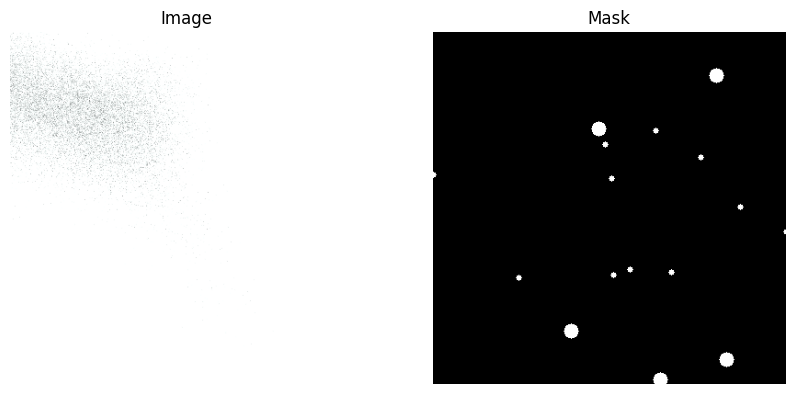

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


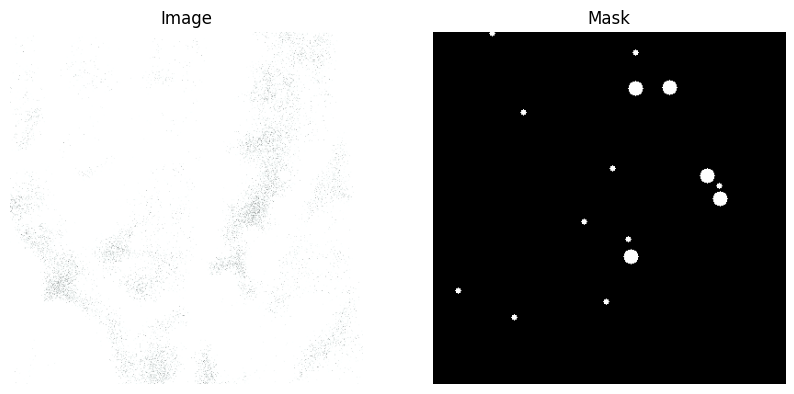

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


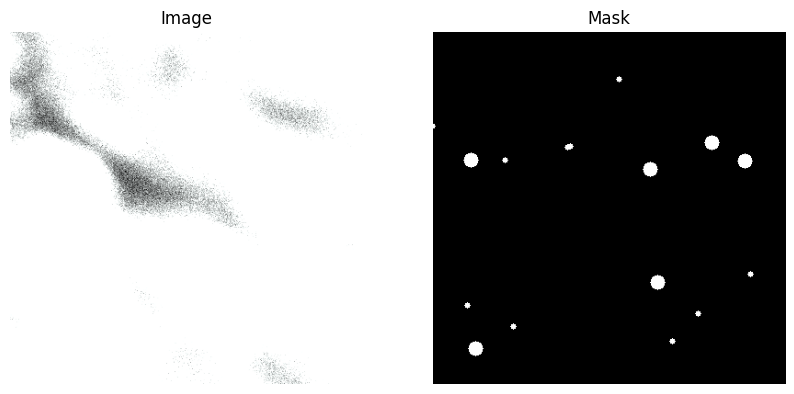

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


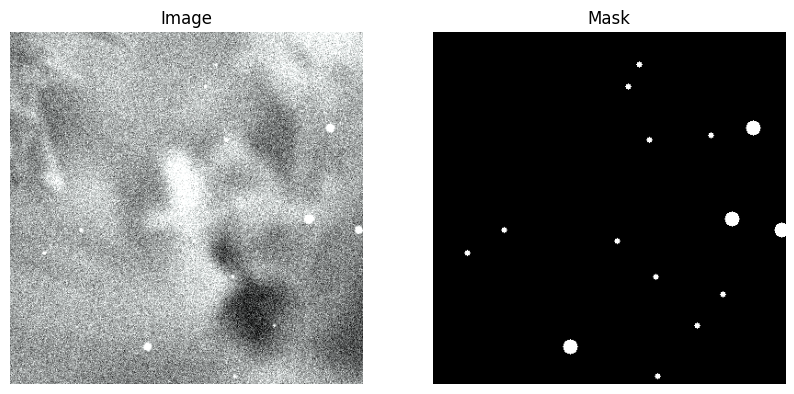

In [30]:
import matplotlib.pyplot as plt
for im, mask in ds:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # print(im)
    im /= 255.0
    axs[0].imshow(im.permute(1, 2, 0).squeeze().numpy(), cmap='gray')

    axs[0].imshow(im.permute(1, 2, 0).squeeze().numpy(), cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(mask.squeeze().numpy(), cmap='gray')
    axs[1].set_title('Mask')
    for ax in axs:
        ax.axis('off')
    plt.show()
    

In [16]:
from datamodule import BinarySegmentationDataModule
dm = BinarySegmentationDataModule(
    train_images_dir='../output_blob/stretched/',
    train_masks_dir='../output_blob/masks_man/',
    val_images_dir='../output_blob/stretched/',
    val_masks_dir='../output_blob/masks_man/',

    transforms= {"train_common": common_transforms,
                 "train_image": image_transforms,
                 "val_common": common_transforms,
                 "val_image": image_transforms},
    img_size=(384, 384),
    batch_size=4,
    num_workers=0,      # SE aumento il numero di workers, va molto più lento
    mask_divisor=True,
)
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

In [17]:
for images, masks in train_loader:
    print(images.shape)  
    print(masks.shape)   
    break
    

torch.Size([4, 1, 384, 384])
torch.Size([4, 1, 384, 384])


In [8]:
model = UNetEfficientNetV2(n_classes = 1).to(device)


In [20]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(50).to(device))  # Adjust pos_weight as needed

# Freeze the encoder layers
for param in model.encoder.parameters():
    param.requires_grad = False

optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 300

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/300], Loss: 1.9074
Epoch [2/300], Loss: 0.9618
Epoch [3/300], Loss: 1.7540
Epoch [4/300], Loss: 1.6096
Epoch [5/300], Loss: 2.8507
Epoch [6/300], Loss: 1.3479
Epoch [7/300], Loss: 2.2544
Epoch [8/300], Loss: 1.4352
Epoch [9/300], Loss: 1.2409
Epoch [10/300], Loss: 1.5800
Epoch [11/300], Loss: 1.6825
Epoch [12/300], Loss: 2.2720
Epoch [13/300], Loss: 1.9952
Epoch [14/300], Loss: 1.4974
Epoch [15/300], Loss: 2.4117
Epoch [16/300], Loss: 2.2132
Epoch [17/300], Loss: 1.5700
Epoch [18/300], Loss: 1.5503
Epoch [19/300], Loss: 1.3633
Epoch [20/300], Loss: 1.7856
Epoch [21/300], Loss: 1.2953
Epoch [22/300], Loss: 1.2627
Epoch [23/300], Loss: 0.8473
Epoch [24/300], Loss: 2.9882
Epoch [25/300], Loss: 1.7916
Epoch [26/300], Loss: 1.7331
Epoch [27/300], Loss: 2.1421
Epoch [28/300], Loss: 1.3843
Epoch [29/300], Loss: 1.3252
Epoch [30/300], Loss: 2.1804
Epoch [31/300], Loss: 1.4803
Epoch [32/300], Loss: 1.9180
Epoch [33/300], Loss: 2.9739
Epoch [34/300], Loss: 1.9229
Epoch [35/300], Loss: 1

KeyboardInterrupt: 

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(30).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=2e-5)

num_epochs = 30

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 1.1494
Epoch [2/30], Loss: 0.9587
Epoch [3/30], Loss: 0.9088
Epoch [4/30], Loss: 1.0527
Epoch [5/30], Loss: 1.2640
Epoch [6/30], Loss: 1.3335
Epoch [7/30], Loss: 1.0817
Epoch [8/30], Loss: 1.1115
Epoch [9/30], Loss: 1.1968
Epoch [10/30], Loss: 1.2793
Epoch [11/30], Loss: 1.1668
Epoch [12/30], Loss: 1.3737
Epoch [13/30], Loss: 1.2027
Epoch [14/30], Loss: 1.1283
Epoch [15/30], Loss: 1.1150
Epoch [16/30], Loss: 1.5179
Epoch [17/30], Loss: 1.3309
Epoch [18/30], Loss: 1.0244
Epoch [19/30], Loss: 1.0257
Epoch [20/30], Loss: 1.0210
Epoch [21/30], Loss: 1.2061
Epoch [22/30], Loss: 1.0787
Epoch [23/30], Loss: 1.0935
Epoch [24/30], Loss: 0.9364
Epoch [25/30], Loss: 1.0520
Epoch [26/30], Loss: 1.1372
Epoch [27/30], Loss: 1.0089
Epoch [28/30], Loss: 1.4646
Epoch [29/30], Loss: 0.9325
Epoch [30/30], Loss: 1.5390


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 30

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 0.9073
Epoch [2/30], Loss: 0.7508
Epoch [3/30], Loss: 0.7573
Epoch [4/30], Loss: 0.7906
Epoch [5/30], Loss: 0.7928
Epoch [6/30], Loss: 0.8196
Epoch [7/30], Loss: 0.6595
Epoch [8/30], Loss: 0.7052
Epoch [9/30], Loss: 0.7022
Epoch [10/30], Loss: 0.7152
Epoch [11/30], Loss: 0.7343
Epoch [12/30], Loss: 0.6949
Epoch [13/30], Loss: 0.6786
Epoch [14/30], Loss: 0.7263
Epoch [15/30], Loss: 0.9771
Epoch [16/30], Loss: 0.7080
Epoch [17/30], Loss: 0.7313
Epoch [18/30], Loss: 0.9220
Epoch [19/30], Loss: 0.7207
Epoch [20/30], Loss: 0.6876
Epoch [21/30], Loss: 0.6449
Epoch [22/30], Loss: 0.6853
Epoch [23/30], Loss: 0.5667
Epoch [24/30], Loss: 0.6455
Epoch [25/30], Loss: 0.9150
Epoch [26/30], Loss: 0.7359
Epoch [27/30], Loss: 0.6138
Epoch [28/30], Loss: 0.9012
Epoch [29/30], Loss: 0.6454
Epoch [30/30], Loss: 0.9133


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(30).to(device))  # Adjust pos_weight as needed
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 15

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/15], Loss: 6.5888
Epoch [2/15], Loss: 1.7401
Epoch [3/15], Loss: 1.5946
Epoch [4/15], Loss: 0.7135
Epoch [5/15], Loss: 1.5041
Epoch [6/15], Loss: 0.7572
Epoch [7/15], Loss: 3.0471
Epoch [8/15], Loss: 1.1452
Epoch [9/15], Loss: 1.3406
Epoch [10/15], Loss: 0.8614
Epoch [11/15], Loss: 1.2275
Epoch [12/15], Loss: 0.9498
Epoch [13/15], Loss: 1.0945
Epoch [14/15], Loss: 1.2063
Epoch [15/15], Loss: 1.2454


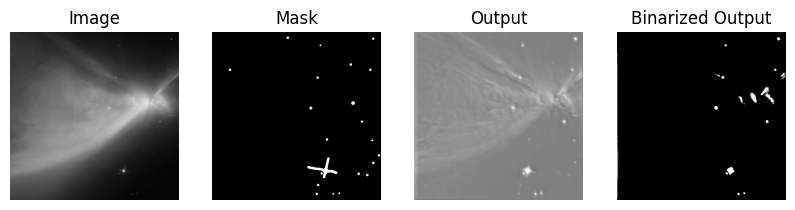

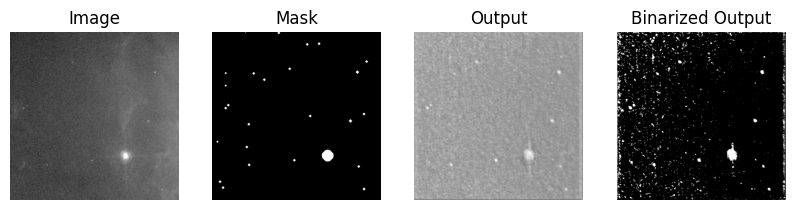

In [ ]:
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        outputs = model(images)
        images = images / 255
        # outputs = outputs.squeeze(1)  # [B, 1, H, W] -> [B, H, W] if needed

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(images[0].cpu().permute(1, 2, 0).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
        plt.title('Image')
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.imshow(masks[0].cpu().squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(1, 4, 3)
        outputs = torch.sigmoid(outputs)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
        plt.title('Output')
        plt.axis('off')
        # binarize the output
        outputs = (outputs > 0.7).float()
        plt.subplot(1, 4, 4)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
        plt.title('Binarized Output')
        plt.axis('off')

In [ ]:
# save model
torch.save(model.state_dict(), 'checkpoints/seg_0.pth')

In [ ]:
from model import UNet
import torch
model = UNet(
    in_channels=1,
    out_channels=1
)
model.load_state_dict(torch.load("checkpoints/seg__gen_1.pth"))
model = model.to(device)
model.eval()

C:\Users\lgand\AppData\Local\Temp\ipykernel_16988\1974319688.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/seg__gen_1.pth

UNet(
  (down1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down3): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (

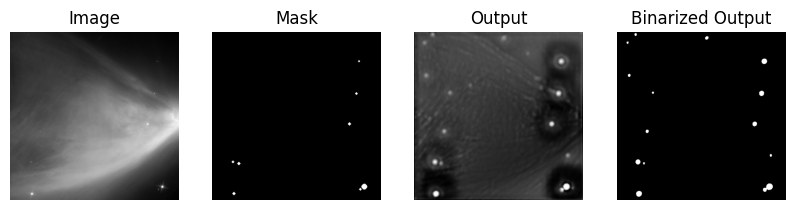

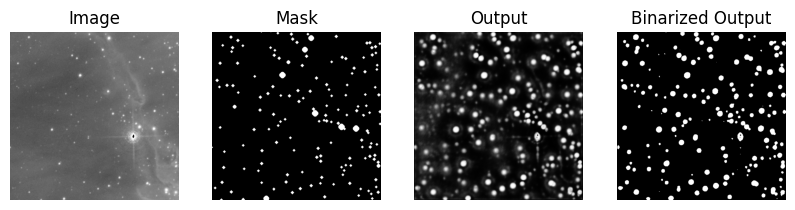

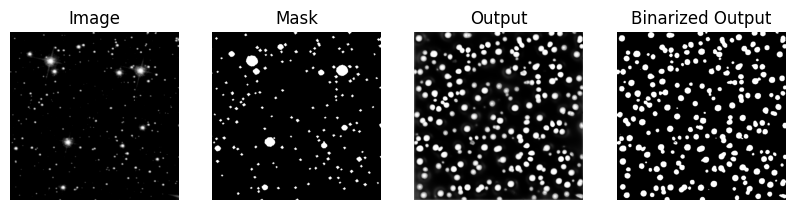

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.float().to(device)
        masks = masks.float().to(device)

        outputs = model(images)
        # outputs = outputs.squeeze(1)  # [B, 1, H, W] -> [B, H, W] if needed

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(images[0].cpu().permute(1, 2, 0).squeeze().numpy(), cmap='gray')
        plt.title('Image')
        plt.axis('off')
        plt.subplot(1, 4, 2)
        plt.imshow(masks[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(1, 4, 3)
        outputs = torch.sigmoid(outputs)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Output')
        plt.axis('off')
        # binarize the output
        outputs = (outputs > 0.5).float()
        plt.subplot(1, 4, 4)
        plt.imshow(outputs[0].cpu().squeeze().numpy(), cmap='gray')
        plt.title('Binarized Output')
        plt.axis('off')